In [96]:
%matplotlib inline

# Импорт пакетов
import os, sys
import collections, functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Функция сплитования общей выборки на тренировочную и тестовую
from sklearn.model_selection import train_test_split

### Метрики расстояния

In [97]:
# Функция рассчета Евклидова расстояния
def l2_dist(x1: np.ndarray, x2: np.ndarray):
    return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))

# Функция рассчета Манхэттэновского расстояния
def l1_dist(x1: np.ndarray, x2: np.ndarray):
    return np.sum(np.abs(x1 - x2), axis=1)

# Фукнция рассчета расстояния Минковского
def minkowski_dist(x1: np.ndarray, x2: np.ndarray, p: int):
    p_dist = np.sum(np.abs(x1 - x2) ** p, axis=1)
    if p == 1:
        return p_dist
    elif p == 2:
        # Использование более быстрой операции извлечения корня, если степень p == 2
        return np.sqrt(p_dist)
    else:
        return np.power(p_dist, 1/p)

### Нормализация

In [98]:
# Функция минимаксного шкалирования (используется для предобработки данных)
def minimax_norm(x: np.ndarray):
    return (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))

# Функция стандартизации (используется для предобработки данных)
def z_norm(x: np.ndarray):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

### Уменьшение выборки

In [99]:
# Функция случайного метода снижения числа элементов выборки
# r - процент элементов, которые нужно оставить в выборке
def random_thinning(x: np.ndarray, y: np.ndarray, r: float):
    size = int(x.shape[0] * r)
    idx = np.random.choice(np.arange(x.shape[0]), size=size)
    return x[idx], y[idx]

### Функция потерь

In [100]:
# Функция рассчета процента ошибок классификатора
def error_rate(y_pred: np.ndarray, y_true: np.ndarray):
    return 1.0 - np.sum(y_pred == y_true) / y_true.shape[0]

### Вывод результатов

In [177]:
def show_results(history, xticks, xlabel, ylabel):
    # Вывод результатов 

    # Выбор набора параметров, при котором наблюдается наименьшая ошибка
    min_errors = [min(errors) for errors in history.values()]
    min_options_idx = np.argmin(min_errors)
    print("Наименьшая ошибка: %s" % (min(min_errors)))

    # Построение графика зависимости ошибки от заданных параметров.
    # Красным показан график функции ошибки для алгоритма с такими параметрами,
    # на которых достигается минимум этой ошибки.
    # В заголовке графика - набор этих параметров.
    plt.figure(figsize=(16, 10))
    for i, (metric, p, weighted, normalization) in enumerate(history.keys()):
        # Выделяем красным оптимальный набор параметров
        if i == min_options_idx:
            plt.plot(xticks, history[(metric, p, weighted, normalization)], c='r') 
            plt.title("Мера: %s, параметр меры Минковского: %s,\nвзвешенный: %s, вид нормализации: %s" % (metric, p, weighted, normalization.__name__))
        else:
            plt.plot(xticks, error_rates[(metric, p, weighted, normalization)], c='b', alpha=0.3, linewidth=0.7)
        plt.xticks(xticks)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.show()
    plt.close()

### Реализация kNN

In [101]:
# Класс-реализация классификатора по методу k-nearest neighbours
class KNN(object):
    def __init__(self, k=5, parzen_window_size=None, metric='l2', p=None, weighted=False):
        
        # Параметрами инициализации являются:
        # k - количество соседей
        # parzen_window_size - размер Парзеновского окна 
        #                      (если инициализированно, то обычный поиск по k-ближайшим соседям не производится)
        # metric = ['l1'|'l2'|'minkowski'] - выбор формулы рассчета расстояния
        # p - степень для расстояния Минковского
        # weighted - если True, то при подсчете голосов ближайших соседей учитывается их удаленность от текущего объекта
        
        self.k = k
        self.parzen_window_size = parzen_window_size
        self.metric = l2_dist
        self.weighted = weighted
        if metric == 'l1':
            self.metric = l1_dist
        elif metric == 'minkowski':
            self.metric = functools.partial(minkowski_dist, p=p)
            
            
    def __count_votes(self, indices):
        
        # Подсчет голосов без взвешивания
        # indices - индексы ближайших соседей (или соседей, попавших в окно Парзена)
        
        # получение меток классов ближайших соседей
        votes = self.train_y[indices]
        
        # составление словаря-счетчика для каждой уникальной метки соседа
        # и подсчет наиболее встречающегося класса
        votes_counter = collections.Counter(votes)
        sorted_items = sorted(votes_counter.items(), key=lambda x: (-x[1], x[0]))[0]
        return sorted_items[0]
    
    
    def __count_votes_weighted(self, indices, weights):
        
        # Подсчет голосов со взвешиванием
        # indices - индексы ближайших соседей (или соседей, попавших в окно Парзена)
        # weights - веса ближайших соседей
        
        # функция идентична предыдущей с тем отличием,
        # что при подсчете количества объектов с одной меткой класса,
        # суммируются не единицы, а веса элементов
        votes_counter = collections.defaultdict(float)
        for index in indices:
            votes_counter[self.train_y[index]] += weights[index]
        sorted_items = sorted(votes_counter.items(), key=lambda x: (-x[1], x[0]))[0]
        return sorted_items[0]
    
    
    def __kn_index_search(self, x, k):
        
        # Выбор k-ближайших соседей.
        # Метод возвращает индексы соседей
        
        # получить расстояния от текущего объекта до всех объектов из тренировочной выборки
        distances = self.metric(x, self.train_X)
        
        # если используется взвешенный вариант алгоритма,
        # то высчитываем веса, как обратное расстояние до объекта
        if self.weighted:
            self.weights = 1.0 / distances
            
        # выбираем индексы ближайших соседей
        return np.argsort(distances)[:k]
    
    
    def __parzen_index_search(self, x, s):
        
        # Выбор соседей, попавших в Парзеновское окно.
        # Также возвращает индексы соседей
        
        # Функция идентична предыдущей.
        # Позволяет выбрать ближайших соседей (со взвешиванием и без)
        # с использованием окна Парзена
        distances = self.metric(x, self.train_X)
        if self.weighted:
            self.weights = 1.0 / distances
        return np.argwhere(distances < self.parzen_window_size).reshape(1, -1)[0]        
    
    
    def fit(self, train_X: np.ndarray, train_y: np.ndarray):
        
        # Метод подгонки алгоритма
        # По сути - запоминает всю выборку.
        self.train_y = train_y
        self.train_X = train_X
    
    
    def predict(self, X: np.ndarray):
        
        # Метод предсказания принадлежности объекта классу        
        y_pred = []
        
        # Перебор всех объектов тестовой выборки
        for x_test in X:
            # Если используется метод парзеновского окна, то ищем k-соседей, попавших в окно
            if self.parzen_window_size:
                idx = self.__parzen_index_search(x_test, self.parzen_window_size)
                
                # Если в окно не попало ни одного элемента, то ищем просто три ближайших соседа
                if idx.size == 0:
                    idx = self.__kn_index_search(x_test, 3)
            else:
                # В другом случае классический метод k-соседей
                idx = self.__kn_index_search(x_test, self.k)
                
            if not self.weighted:
                # Если не используется взвешенный вариант алгоритма, 
                # то ищем наиболее частый класс, среди соседей
                majority_vote = self.__count_votes(idx)
            else:
                # Если испольуется взвешенный, 
                # то находим сумму весов соседей с одним классом и выбираем самый "весомый"
                majority_vote = self.__count_votes_weighted(idx, self.weights)
            y_pred.append(majority_vote)
        return np.array(y_pred)

In [102]:
# Загрузка датасета
df = pd.read_csv("../../Datasets/Pulsar Stars/HTRU_2.csv", 
                 names=['mean_ie', 'std_ie', 'ex_kur_ie', 'skew_ie',
                        'mean_dmsnr', 'std_mean_dmsnr', 'ex_kur_dmsnr', 'skew_dmsnr',
                        'class'])
print(df.shape)
df.head()

(17898, 9)


mean_ie     std_ie  ex_kur_ie   skew_ie  mean_dmsnr  std_mean_dmsnr  \
0  140.562500  55.683782  -0.234571 -0.699648    3.199833       19.110426   
1  102.507812  58.882430   0.465318 -0.515088    1.677258       14.860146   
2  103.015625  39.341649   0.323328  1.051164    3.121237       21.744669   
3  136.750000  57.178449  -0.068415 -0.636238    3.642977       20.959280   
4   88.726562  40.672225   0.600866  1.123492    1.178930       11.468720   

   ex_kur_dmsnr  skew_dmsnr  class  
0      7.975532   74.242225      0  
1     10.576487  127.393580      0  
2      7.735822   63.171909      0  
3      6.896499   53.593661      0  
4     14.269573  252.567306      0

In [103]:
# Разделение данных на признаки и метки
X, y = df.drop(columns=['class']).values, df['class'].values

# Случайное прореживание данных
X, y = random_thinning(X, y, r=0.8)

In [106]:
# Переменные для поиска по решетке
weighted_ = [True, False]
normalization_ = [minimax_norm, z_norm]

# Рассматриваемые значения k
k_ = range(1, 20, 4) 

# Рассматриваемые значения размера окна Парзена
s_ = np.linspace(0.1, 10.0, 5) 

# Эта переменная создает комбинации меры расстояния и параметра p (для меры Минковского)
# Сделано для предотвращения ненужных итераций по переменной p, когда выбраны меры l1 или l2.
metrics_with_p_ = [('l1', None), ('l2', None)] + list(zip(['minkowski'] * 10, range(1, 10)))
print(metrics_with_p_)

[('l1', None), ('l2', None), ('minkowski', 1), ('minkowski', 2), ('minkowski', 3), ('minkowski', 4), ('minkowski', 5), ('minkowski', 6), ('minkowski', 7), ('minkowski', 8), ('minkowski', 9)]


In [107]:
# Поиск по решетке без использования окна Парзена
error_rates = collections.defaultdict(list)

overall_iters = len(normalization_) * len(weighted_) * len(metrics_with_p_) * len(k_)
curr_iter = 1

for normalization in normalization_:
    for weighted in weighted_:
        for metric, p in metrics_with_p_:
            for k in k_:
                print("Итерация %s из %s" % (curr_iter, overall_iters))
                # Нормализация данных
                X_norm = normalization(X)
                
                # Разделение данных на тренировочные и тестовые выборки
                train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8)
                
                # Создание объекта kNN
                clf = KNN(k=k, metric=metric, p=p, weighted=weighted)
                
                # "Обучение" kNN
                clf.fit(train_X, train_y)
                
                # Предсказание меток классов для тестовой выборки
                pred_y = clf.predict(test_X)
                
                # Сохранение истории обучения
                error_rates[(metric, p, weighted, normalization)].append(error_rate(pred_y, test_y))
                
                curr_iter += 1

Итерация 1 из 220


/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide


Итерация 2 из 220
Итерация 3 из 220
Итерация 4 из 220
Итерация 5 из 220
Итерация 6 из 220
Итерация 7 из 220
Итерация 8 из 220
Итерация 9 из 220
Итерация 10 из 220
Итерация 11 из 220
Итерация 12 из 220
Итерация 13 из 220
Итерация 14 из 220
Итерация 15 из 220
Итерация 16 из 220
Итерация 17 из 220
Итерация 18 из 220
Итерация 19 из 220
Итерация 20 из 220
Итерация 21 из 220
Итерация 22 из 220
Итерация 23 из 220
Итерация 24 из 220
Итерация 25 из 220
Итерация 26 из 220
Итерация 27 из 220
Итерация 28 из 220
Итерация 29 из 220
Итерация 30 из 220
Итерация 31 из 220
Итерация 32 из 220
Итерация 33 из 220
Итерация 34 из 220
Итерация 35 из 220
Итерация 36 из 220
Итерация 37 из 220
Итерация 38 из 220
Итерация 39 из 220
Итерация 40 из 220
Итерация 41 из 220
Итерация 42 из 220
Итерация 43 из 220
Итерация 44 из 220
Итерация 45 из 220
Итерация 46 из 220
Итерация 47 из 220
Итерация 48 из 220
Итерация 49 из 220
Итерация 50 из 220
Итерация 51 из 220
Итерация 52 из 220
Итерация 53 из 220
Итерация 54 из 220
И

Наименьшая ошибка: 0.009776536312849138


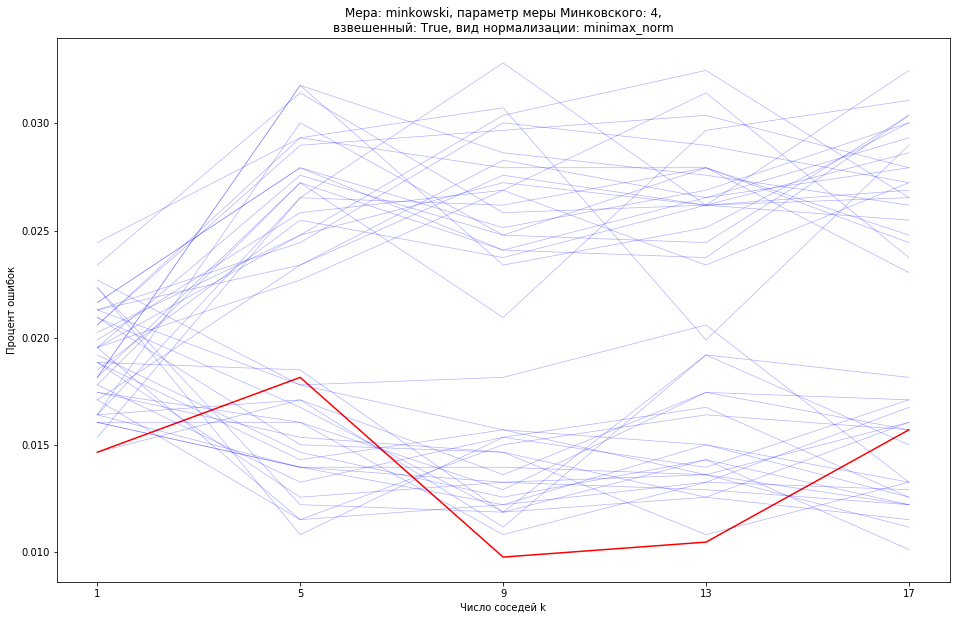

In [178]:
show_results(error_rates, list(k_), "Число соседей k", "Процент ошибок")

In [137]:
# Поиск по решетке c использованием окна Парзена

overall_iters = len(normalization_) * len(weighted_) * len(metrics_with_p_) * len(k_)
curr_iter = 1

error_rates_parzen = collections.defaultdict(list)
for normalization in normalization_:
    for weighted in weighted_:
        for metric, p in metrics_with_p_:
            for s in s_:
                print("Итерация %s из %s" % (curr_iter, overall_iters))
                # Нормализация данных
                X_norm = normalization(X)
                
                # Разделение данных на тренировочные и тестовые выборки
                train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8)
                
                # Создание объекта kNN
                clf = KNN(k=3, parzen_window_size=s, metric=metric, p=p, weighted=weighted)
                
                # "Обучение" kNN
                clf.fit(train_X, train_y)
                
                # Предсказание меток классов для тестовой выборки
                pred_y = clf.predict(test_X)
                
                # Сохранение истории обучения
                error_rates_parzen[(metric, p, weighted, normalization)].append(error_rate(pred_y, test_y))
                
                curr_iter += 1    

Итерация 1 из 220


/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide


Итерация 2 из 220
Итерация 3 из 220
Итерация 4 из 220
Итерация 5 из 220
Итерация 6 из 220
Итерация 7 из 220
Итерация 8 из 220
Итерация 9 из 220
Итерация 10 из 220
Итерация 11 из 220
Итерация 12 из 220
Итерация 13 из 220
Итерация 14 из 220
Итерация 15 из 220
Итерация 16 из 220
Итерация 17 из 220
Итерация 18 из 220
Итерация 19 из 220
Итерация 20 из 220
Итерация 21 из 220
Итерация 22 из 220
Итерация 23 из 220
Итерация 24 из 220
Итерация 25 из 220
Итерация 26 из 220
Итерация 27 из 220
Итерация 28 из 220
Итерация 29 из 220
Итерация 30 из 220
Итерация 31 из 220
Итерация 32 из 220
Итерация 33 из 220
Итерация 34 из 220
Итерация 35 из 220
Итерация 36 из 220
Итерация 37 из 220
Итерация 38 из 220
Итерация 39 из 220
Итерация 40 из 220
Итерация 41 из 220
Итерация 42 из 220
Итерация 43 из 220
Итерация 44 из 220
Итерация 45 из 220
Итерация 46 из 220
Итерация 47 из 220
Итерация 48 из 220
Итерация 49 из 220
Итерация 50 из 220
Итерация 51 из 220
Итерация 52 из 220
Итерация 53 из 220
Итерация 54 из 220
И

Наименьшая ошибка: 0.00942737430167595


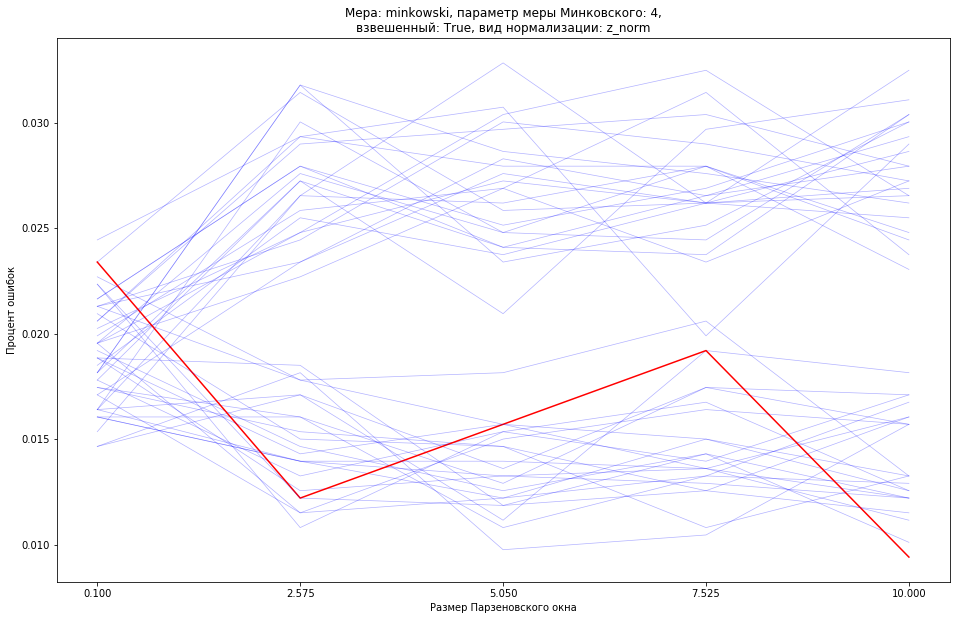

In [179]:
show_results(error_rates_parzen, s_, "Размер Парзеновского окна", "Процент ошибок")